<font color= red> __Data Prep workflow:__ </font>

After loading the data we dropped timestamp since it was not needed. we removed the 18 duplicate records.

Created Xij matrix with the following approach:
* Created the UserXMovies with pivot function in pandas and converted this to numpy arrays
* Xij is by the dot product of [MovieXUser].[UserXMatrix] producing [MovieXMovie] Matrix

In [ ]:
##Loading ratings & movies data into GPU

ratings_data = pd.read_csv("/home/team8/Assignment2/ml-latest-small/ratings.csv", delimiter=',')   
movies=pd.read_csv("/home/team8/Assignment2/ml-latest-small/movies.csv", delimiter=',') 
movie_ratings = pd.merge(ratings_data, movies, on='movieId') 

## Pre-processing: 

movies_temp = ratings_data[["movieId"]].drop_duplicates()
movies_temp = pd.merge(movies_temp,movies[["movieId","title"]],on="movieId",how="left")
movies_temp = movies_temp.sort_values(by="movieId").reset_index(drop=True)

movies_dict = {row["title"]:row["movieId"] for index,row in movies_temp.iterrows()}
title_dict = {row["title"]:row["movieId"] for index,row in movies_temp.iterrows()}

ratings_data.drop(["timestamp"], axis = 1, inplace = True)
ratings_modified = ratings_data

In [ ]:
## Framing User-Movie matrix with the data 
pivot = ratings_data.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
pivot_matrix = pivot.as_matrix()
pivot_matrix = (pivot_matrix >=4).astype(int) 
movie_matrix = np.zeros([pivot_matrix.shape[0] , pivot_matrix.shape[0]], dtype=int)

In [ ]:
for i in range(pivot_matrix.shape[0]) :
    for j in range(i+1, pivot_matrix.shape[0]):
        movie_matrix[i][j] = np.dot(pivot_matrix[i], pivot_matrix[j])
        movie_matrix[j][i] = movie_matrix[i][j]
pickle.dump(movie_matrix, open("xij_matrix.pkl","wb"))

# Q2.B Optimize the Gradients 

We have created a linear model with three optimizers Stochastic Gradient Descent, Adagrad, Adam with learning rates 0.000001,0.01 and random the model with 1500 iterations. Final loss values is as below: <br>
<font color= green> __SGD, LR=0.000001__ - Loss: **6641307** <br>
__Adagrad, LR=0.000001__ - Loss:  **29276254208** <br>
__Adam, LR=0.000001__ - Loss: **29262352384** <br>
<br>
__SGD, LR=0.01__ - Loss: **NaN** <br>
__Adagrad, LR=0.01__ - Loss:  **4300306432** <br>
__Adam, LR=0.01__ - Loss: **29380904960** <br></font>

<font color= red>__SGD with Learning rate is the best model with lowest loss of 0.000001__ <br>


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
### Validation of matrix
movie_list1 = list(ratings_data.userId[(ratings_data.movieId==1) & (ratings_data.rating>=4.0)])
movie_list2 = list(ratings_data.userId[(ratings_data.movieId==3) & (ratings_data.rating>=4.0)])
len(set(movie_list1).intersection(movie_list2))

11

In [ ]:
##Buliding a linear model to learn the weights for the movie vectors
class LinReg(nn.Module):
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(input_dim,output_dim))
    
    def forward(self,X):
        #mod = F.linear(X,self.weight,self.bias)
        return self.weight

In [ ]:
##Coding for the Gradient Descent function using 'Pytorch' 
def gradient_optimizer(model,input_dim,output_dim,optimizer,criterion):
    # Move everything to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X = torch.randn(9724,300)
    y = torch.from_numpy(movie_matrix).float()
    X, y = X.to(device), y.to(device)
    
    loss_fn = []
    for i in range(0,1500):
        # Train step
        model.train()
        optimizer.zero_grad()
        
        y_ = model(X)

        weights_squared = torch.mm(y_,y_.transpose(1,-2))
        loss = criterion(weights_squared, y)

        loss.backward()
        optimizer.step()

        loss_fn.append(loss)
        if i%100==0:
            print("Iteration"+str(i)+":",loss.item())
    print("\n")
    return [model.weight.detach().cpu().numpy(),loss_fn]

In [ ]:
##Model building to learn the weights using gradient descent to find movie embeddings

##Defining input Dimensions
input_dim = 9724
output_dim = 300

## Building models with varying leaning rates(step size) and changing optimizers
model = LinReg(input_dim,output_dim).to(device)
optimizer1 = optim.SGD(model.parameters(), lr=0.000001)
criterion = nn.MSELoss(reduction="sum")
[vectors1,loss_temp1] = gradient_optimizer(model,input_dim,output_dim,optimizer1,criterion)

model = LinReg(input_dim,output_dim).to(device)
optimizer2 = optim.Adagrad(model.parameters(),lr=0.000001)
criterion = nn.MSELoss(reduction="sum")
[vectors2,loss_temp2] = gradient_optimizer(model,input_dim,output_dim,optimizer2,criterion)

model = LinReg(input_dim,output_dim).to(device)
optimizer3 = optim.Adam(model.parameters(),lr=0.000001)
criterion = nn.MSELoss(reduction="sum")
[vectors3,loss_temp3] = gradient_optimizer(model,input_dim,output_dim,optimizer3,criterion)

model = LinReg(input_dim,output_dim).to(device)
optimizer4 = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction="sum")
[vectors4,loss_temp4] = gradient_optimizer(model,input_dim,output_dim,optimizer4,criterion)


model = LinReg(input_dim,output_dim).to(device)
optimizer5 = optim.Adagrad(model.parameters(),lr=0.01)
criterion = nn.MSELoss(reduction="sum")
[vectors5,loss_temp5] = gradient_optimizer(model,input_dim,output_dim,optimizer5,criterion)

optimizer6 = optim.Adam(model.parameters(),lr=0.01)
model = LinReg(input_dim,output_dim).to(device)
criterion = nn.MSELoss(reduction="sum")
[vectors6,loss_temp6] = gradient_optimizer(model,input_dim,output_dim,optimizer6,criterion)


Iteration0: 29307406336.0
Iteration100: 379003808.0
Iteration200: 111303944.0
Iteration300: 56780972.0
Iteration400: 35981116.0
Iteration500: 25531626.0
Iteration600: 19506868.0
Iteration700: 15703202.0
Iteration800: 13115771.0
Iteration900: 11254880.0
Iteration1000: 9859927.0
Iteration1100: 8779908.0
Iteration1200: 7920875.5
Iteration1300: 7221966.0
Iteration1400: 6642680.5
Iteration0: 29301809152.0
Iteration100: 29300045824.0
Iteration200: 29299226624.0
Iteration300: 29298575360.0
Iteration400: 29298350080.0
Iteration500: 29298126848.0
Iteration600: 29297934336.0
Iteration700: 29297737728.0
Iteration800: 29297545216.0
Iteration900: 29297354752.0
Iteration1000: 29297164288.0
Iteration1100: 29296971776.0
Iteration1200: 29296896000.0
Iteration1300: 29296861184.0
Iteration1400: 29296824320.0
Iteration0: 29297145856.0
Iteration100: 29287899136.0
Iteration200: 29278654464.0
Iteration300: 29269413888.0
Iteration400: 29260177408.0
Iteration500: 29250938880.0
Iteration600: 29241708544.0
Iteration700: 29232480256.0
Iteration800: 29223256064.0
Iteration900: 29214035968.0
Iteration1000: 29204826112.0
Iteration1100: 29195626496.0
Iteration1200: 29186433024.0
Iteration1300: 29177241600.0
Iteration1400: 29168052224.0
Iteration0: 29334024192.0
Iteration100: nan
Iteration200: nan
Iteration300: nan
Iteration400: nan
Iteration500: nan
Iteration600: nan
Iteration700: nan
Iteration800: nan
Iteration900: nan
Iteration1000: nan
Iteration1100: nan
Iteration1200: nan
Iteration1300: nan
Iteration1400: nan
Iteration0: 29272051712.0
Iteration100: 16680867840.0
Iteration200: 13242199040.0
Iteration300: 11168641024.0
Iteration400: 9717693440.0
Iteration500: 8624044032.0
Iteration600: 7761005568.0
Iteration700: 7058094592.0
Iteration800: 6472117248.0
Iteration900: 5974760960.0
Iteration1000: 5546508288.0
Iteration1100: 5173380096.0
Iteration1200: 4845047808.0
Iteration1300: 4553684480.0
Iteration1400: 4293233152.0
Iteration0: 29285044224.0
Iteration100: 29285048320.0
Iteration200: 29285048320.0
Iteration300: 29285048320.0
Iteration400: 29285048320.0
Iteration500: 29285048320.0
Iteration600: 29285046272.0
Iteration700: 29285048320.0
Iteration800: 29285048320.0
Iteration900: 29285048320.0
Iteration1000: 29285048320.0
Iteration1100: 29285048320.0
Iteration1200: 29285048320.0
Iteration1300: 29285048320.0
Iteration1400: 29285044224.0

In [ ]:
loss_fn= [loss_temp1,loss_temp2,loss_temp3,loss_temp4,loss_temp5,loss_temp6]
vec = [vectors1,vectors2,vectors3,vectors4,vectors5,vectors6]

In [ ]:
##Plotting the loss functions for different models
plt.plot(range(len(loss_temp1)),loss_temp1,'g-')
plt.plot(range(len(loss_temp2)),loss_temp2,'b-')
plt.plot(range(len(loss_temp3)),loss_temp3,'y-')
#plt.plot(range(len(loss_temp4)),loss_temp4,'r-')
plt.plot(range(len(loss_temp5)),loss_temp5,'c-')
plt.plot(range(len(loss_temp6)),loss_temp6,'p-')
plt.title("Loss of Various Optimizers with different learning rates   \n")
plt.xlabel('Number of iterations of gradient update')
plt.ylabel('Loss')
plt.show()

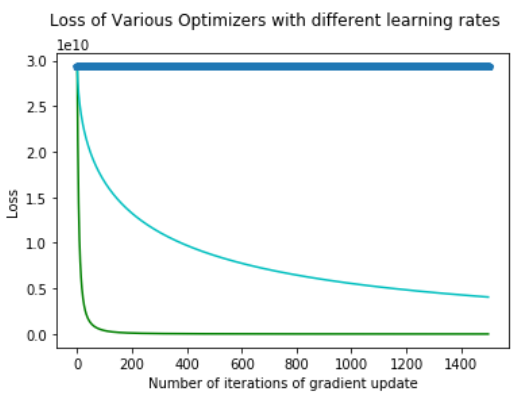

In [ ]:
## Saving the learnt vectors to pickle files for future use
pickle.dump(vectors1,open("vector1.pkl","wb"))
pickle.dump(vectors2,open("vector2.pkl","wb"))
pickle.dump(vectors3,open("vector3.pkl","wb"))
pickle.dump(vectors5,open("vector5.pkl","wb"))
pickle.dump(vectors6,open("vector6.pkl","wb"))


# Q2.3 Find Top 10 recommendations for each movie 

<font color = green>__-->__ Recommondation strategy - We found the piecewise cosine similarity for the movie embeddings and found the top 10 movies with highest similarity value.<br>
__-->__We found  the learning rate with an optimizer which converges quicker in less number of iterations<br>    
__-->__ We ran this for all the combinations of the optimizers and learning rates and found that the recommendations are different. <br>
__-->__The difference in the loss value is because of the standard learning rates across  different optimizers. <br>
__-->__We re ran adam optimizer with a higher learning rate and found recommendations most similar to our best model from above which is Stochastic Gradient Descent. </font><br>

<font color= red> __Stochastic Gradient Descent with Learning Rate 0.000001 - Recommendations:__ </font> <br>

<font color = green>__MOVIE NAME:Toy Story (1995)__ <br></font>
 
 RECOMMENDATIONS: <br>
 Aladdin (1992) <br>
 Jurassic Park (1993) <br>
 Back to the Future (1985) <br>
 Star Wars: Episode IV - A New Hope (1977) <br>
 Forrest Gump (1994) <br>
 Willy Wonka & the Chocolate Factory (1971) <br>
 Princess Bride, The (1987) <br>
 Silence of the Lambs, The (1991) <br>
 Terminator 2: Judgment Day (1991) <br>
 E.T. the Extra-Terrestrial (1982) <br>
 
Adam with Learning Rate 0.000001 - Recommendations: <br>
<font color = green>__MOVIE NAME:Toy Story (1995)__ <br></font>
 
 RECOMMENDATIONS:<br>
 La Cérémonie (1995) <br>
 Terminator 2: Judgment Day (1991) <br>
 Prozac Nation (2001) <br>
 Lassie (1994) <br>
 Sanjuro (Tsubaki Sanjûrô) (1962) <br>
 Little Nicky (2000) <br>
 Beyond the Clouds (Al di là delle nuvole) (1996) <br>
 Beautiful Creatures (2000) <br>
 Suicide Squad (2016) <br>
 Catch and Release (2006) <br>
 
Adam with Learning Rate 0.025 - Recommendations: <br>

<font color = green>__MOVIE NAME:Toy Story (1995)__ <br></font>
 
 RECOMMENDATIONS:
 Forrest Gump (1994)<br>
 Star Wars: Episode IV - A New Hope (1977)<br>
 Jurassic Park (1993)<br>
 Silence of the Lambs, The (1991)<br>
 Shawshank Redemption, The (1994)<br>
 Aladdin (1992)<br>
 Sixth Sense, The (1999)<br>
 Lion King, The (1994)<br>
 Star Wars: Episode V - The Empire Strikes Back (1980)<br>
 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)<br>
 

In [ ]:
def generate_recommendations(vec_mat,movies,movies_temp):
    vec_mat1 = np.asmatrix(np.asarray(vec_mat))
    vec_mat1 = pd.DataFrame(vec_mat1)
    vec_mat_transpose = vec_mat1.T
    sim = cosine_similarity(vec_mat1)
    sim_mat = np.asmatrix(np.asarray(sim))
    sim_df = pd.DataFrame(sim_mat)
    sin = pd.concat([movies_temp, sim_df], axis=1)
    top10(movies,sin)

In [ ]:
def top10(movies,sin):
    for movie in movies:
        find_mov = sin[sin.title ==movie]
        store_mov = find_mov.iloc[:,2:]
        store_mov = store_mov.T
        store_mov = pd.concat([store_mov, movies_temp], axis=1)
        sort = store_mov.sort_values(store_mov.columns[0], ascending = False)
        top_n = sort.iloc[1:11]
        #print({"Movie Name:"+movie},"\n",{"Recommendations:"+",".join(top_n.title.values)},"\n")
        print("MOVIE NAME:"+movie,"\n","\n","RECOMMENDATIONS:"+"\n"," ".join(top_n.title.values+"\n"),"\n")

<font color = green> ## __Top 10 Movie recommendations for different models__</font>

In [ ]:
#For SGD with Learning Rate 0.000001
generate_recommendations(vectors1,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 Aladdin (1992)
 Jurassic Park (1993)
 Back to the Future (1985)
 Star Wars: Episode IV - A New Hope (1977)
 Forrest Gump (1994)
 Willy Wonka & the Chocolate Factory (1971)
 Princess Bride, The (1987)
 Silence of the Lambs, The (1991)
 Terminator 2: Judgment Day (1991)
 E.T. the Extra-Terrestrial (1982)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Aladdin (1992)
 Jumanji (1995)
 Lion King, The (1994)
 Mrs. Doubtfire (1993)
 Back to the Future Part II (1989)
 Beauty and the Beast (1991)
 Independence Day (a.k.a. ID4) (1996)
 Jurassic Park (1993)
 GoldenEye (1995)
 Toy Story (1995)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Fugitive, The (1993)
 Dances with Wolves (1990)
 Jurassic Park (1993)
 Braveheart (1995)
 Forrest Gump (1994)
 Lion King, The (1994)
 Aladdin (1992)
 Shawshank Redemption, The (1994)
 Clear and Present Danger (1994)
 True Lies (1994)
 

In [ ]:
#For Adagradwith Learning Rate 0.000001
generate_recommendations(vectors2,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 Goonies, The (1985)
 Dirty 30 (2016)
 End of Watch (2012)
 American Werewolf in London, An (1981)
 Butcher's Wife, The (1991)
 Nadine (1987)
 Kung Pow: Enter the Fist (2002)
 Charlie Bartlett (2007)
 10 (1979)
 Untamed Heart (1993)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Lookout, The (2007)
 Awakenings (1990)
 Fall (1997)
 Year One (2009)
 Garfield: The Movie (2004)
 Majestic, The (2001)
 One, The (2001)
 Millennium (1989)
 Semi-Pro (2008)
 Scooby-Doo! and the Samurai Sword (2009)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Baby Boom (1987)
 Tremors II: Aftershocks (1996)
 Paulie (1998)
 Dead Man Walking (1995)
 Wrong Arm of the Law, The (1963)
 Thirteen (2003)
 Gamers, The: Dorkness Rising (2008)
 Back to the Future Part III (1990)
 Lover, The (Amant, L') (1992)
 Unbearable Lightness of Being, The (1988)

In [ ]:
#For Adam with Learning Rate 0.000001
generate_recommendations(vectors3,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 La Cérémonie (1995)
 Terminator 2: Judgment Day (1991)
 Prozac Nation (2001)
 Lassie (1994)
 Sanjuro (Tsubaki Sanjûrô) (1962)
 Little Nicky (2000)
 Beyond the Clouds (Al di là delle nuvole) (1996)
 Beautiful Creatures (2000)
 Suicide Squad (2016)
 Catch and Release (2006)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Bloodsport: The Dark Kumite (1999)
 Youth Without Youth (2007)
 Pan's Labyrinth (Laberinto del fauno, El) (2006)
 Yes Men, The (2003)
 Boxcar Bertha (1972)
 Tenchi Muyô! In Love (1996)
 Son in Law (1993)
 Monster House (2006)
 Room (2015)
 Raise the Titanic (1980)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Life with Mikey (1993)
 The Longest Week (2014)
 Playing the Victim (Izobrazhaya zhertvu) (2006)
 World Traveler (2001)
 Red Dawn (1984)
 Tournament, The (2009)
 Ladykillers, The (1955)
 Ernest Scared Stupid (1991)
 Empire Records (1995)
 Career Opportunities (1991)

In [ ]:
#For Adagrad with Learning Rate 0.01
generate_recommendations(vectors5,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 Hell Ride (2008)
 Autumn Spring (Babí léto) (2001)
 Scary Movie 2 (2001)
 Best Years of Our Lives, The (1946)
 Mystery Men (1999)
 Secret in Their Eyes, The (El secreto de sus ojos) (2009)
 Prime Suspect 6: The Last Witness (2003)
 Miller's Crossing (1990)
 Last Days of Disco, The (1998)
 Maid to Order (1987)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Last Wave, The (1977)
 Female Perversions (1996)
 My Bodyguard (1980)
 Life or Something Like It (2002)
 Brother (Brat) (1997)
 Clay Pigeons (1998)
 Two for the Money (2005)
 Born on the Fourth of July (1989)
 L.A. Story (1991)
 Love Serenade (1996)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Galaxy of Terror (Quest) (1981)
 My Family (1995)
 Big Short, The (2015)
 My Stepmother Is an Alien (1988)
 Forrest Gump (1994)
 Watership Down (1978)
 The Hunger Games: Mockingjay - Part 2 (2015)
 Taxi 3 (2003)
 Pride and Prejudice and Zombies (2016)
 Quadrophenia (1979)

In [ ]:
#For Adam with Learning Rate 0.01
generate_recommendations(vectors6,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 Alice in Wonderland (1933)
 Double Happiness (1994)
 Trainwreck (2015)
 Secret of Kells, The (2009)
 Bread and Tulips (Pane e tulipani) (2000)
 Jesus' Son (1999)
 Walk of Shame (2014)
 Stretch (2014)
 Loving Vincent (2017)
 Vampires (1998)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Alice in Wonderland (1951)
 Time Out (L'emploi du temps) (2001)
 Deepwater Horizon (2016)
 Amityville Horror, The (2005)
 Hunt For Gollum, The (2009)
 Good bye, Lenin! (2003)
 Pusher II: With Blood on My Hands (2004)
 The Return of Don Camillo (1953)
 Secret Society (2002)
 The Longest Week (2014)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Charlie Bartlett (2007)
 Echelon Conspiracy (2009)
 Crimson Pirate, The (1952)
 In the Land of Women (2007)
 Ro.Go.Pa.G. (1963)
 Toni Erdmann (2016)
 Club Paradise (1986)
 Scaramouche (1952)
 Halloween II (1981)
 Disorganized Crime (1989)

In [ ]:
model = LinReg(input_dim,output_dim).to(device)
optimizer7 = optim.Adam(model.parameters(),lr=0.025)
criterion = nn.MSELoss(reduction="sum")
[vectors7,loss_temp7] = gradient_optimizer(model,input_dim,output_dim,optimizer7,criterion)

Iteration0: 29367412736.0
Iteration100: 53739824.0
Iteration200: 15851264.0
Iteration300: 7512120.0
Iteration400: 4513847.0
Iteration500: 3131482.5
Iteration600: 2405873.0
Iteration700: 1995371.5
Iteration800: 1749998.375
Iteration900: 1596326.125
Iteration1000: 1496371.0
Iteration1100: 1429186.125
Iteration1200: 1382649.5
Iteration1300: 1349596.5
Iteration1400: 1325626.375

In [ ]:
plt.plot(range(len(loss_temp1)),loss_temp1,'g-')
plt.plot(range(len(loss_temp7)),loss_temp7,'b-')
plt.title("Loss of Various Optimizers with different learning rates   \n")
plt.xlabel('Number of iterations of gradient update')
plt.ylabel('Loss')
plt.show()

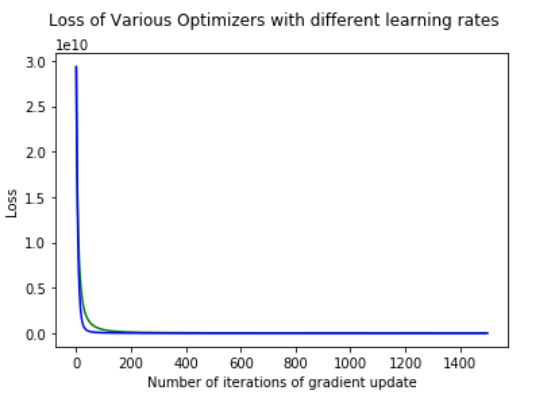

Here green is the original stochastic gradient descent with LR = 0.000001 and blue is adam with new learning rate = 0.25

In [ ]:
#For Adam with Learning Rate 0.01
generate_recommendations(vectors7,["Toy Story (1995)","Home Alone (1990)","Apollo 13 (1995)"],movies_temp)

MOVIE NAME:Toy Story (1995) 
 
 RECOMMENDATIONS:
 Forrest Gump (1994)
 Star Wars: Episode IV - A New Hope (1977)
 Jurassic Park (1993)
 Silence of the Lambs, The (1991)
 Shawshank Redemption, The (1994)
 Aladdin (1992)
 Sixth Sense, The (1999)
 Lion King, The (1994)
 Star Wars: Episode V - The Empire Strikes Back (1980)
 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
 

MOVIE NAME:Home Alone (1990) 
 
 RECOMMENDATIONS:
 Back to the Future Part II (1989)
 Aladdin (1992)
 Mrs. Doubtfire (1993)
 Jumanji (1995)
 Jurassic Park (1993)
 Lion King, The (1994)
 Beauty and the Beast (1991)
 Meet the Parents (2000)
 Harry Potter and the Goblet of Fire (2005)
 Sandlot, The (1993)
 

MOVIE NAME:Apollo 13 (1995) 
 
 RECOMMENDATIONS:
 Fugitive, The (1993)
 Forrest Gump (1994)
 Jurassic Park (1993)
 Shawshank Redemption, The (1994)
 Braveheart (1995)
 Dances with Wolves (1990)
 Silence of the Lambs, The (1991)
 True Lies (1994)
 Lion King, The (1994)
 Aladdin (1992)